# Brute Force App

In [1]:
import json
import numpy as np
import pandas as pd

from joblib import Parallel, delayed
from tqdm.notebook import tqdm

## Load Data

In [2]:
with open('data/wordle-candidates.json', 'r') as file:
    wordle_candidates = json.load(file)
    
with open('data/wordle-answers.json', 'r') as file:
    wordle_answers = json.load(file)

wordle_candidates = pd.DataFrame(wordle_candidates['words'], columns=['word'])
wordle_answers = pd.DataFrame(wordle_answers['words'], columns=['word'])
wordle_candidates['is_answer'] = 0
wordle_answers['is_answer'] = 1
wordle = wordle_candidates.append(wordle_answers).reset_index(drop=True)

In [3]:
words_all = pd.read_table('data/archive/en_words_1_5-5.txt', delimiter=' ', header=None, index_col=None,
                         names=['word_len', 'word_freq', 'n_articles']).reset_index()
words_all = words_all.rename(columns={'index': 'word'})

# Filter by english
alphabet = list('abcdefghijklmnopqrstuvwxyz')
words_all = words_all.loc[words_all.word.apply(lambda x: all([l in alphabet for l in x]))].reset_index(drop=True)

## Prepare Artifacts

In [4]:
alpha_dict = {l: i for i, l in enumerate(list('abcdefghijklmnopqrstuvwxyz'))}

In [5]:
# Initialise solutions vector
solutions = np.zeros((wordle.shape[0], 26, 5))
for i, word in enumerate(wordle.word):
    for j, l in enumerate(word):
        solutions[i, alpha_dict[l], j] = 1

## Game Logic

In [6]:
def get_feedback(input_word, solution):
    output = ''
    for i in range(5):
        if input_word[i] == solution[i]:
            output += 'G'
        elif input_word[i] in solution:
            output += 'Y'
        else:
            output += 'X'
    return output

In [7]:
def filter_wordset(input_word, feedback, wordset):
    newset = wordset.copy()
    for i in range(5):
        if feedback[i] == 'G':
            newset = newset.loc[newset.word.str[i] == input_word[i]]
        elif feedback[i] == 'Y':
            # newset = newset.loc[newset.word.str.contains(input_word[i])]
            newset = newset.loc[newset.word.str.contains(input_word[i]) & newset.word.apply(lambda x: x[i] != input_word[i])]
        else:
            newset = newset.loc[~newset.word.str.contains(input_word[i])]
    return newset

## Vector Ops

In [8]:
def init_vec(word):
    mat = np.zeros((26, 5))
    for i, l in enumerate(word):
        mat[alpha_dict[l], i] = 1
    return mat

In [9]:
def get_scores(word, mask):
    word_vec = init_vec(word)
    solutions_masked = solutions[mask]
    greens = solutions_masked * word_vec
    yellows = word_vec * (
        (solutions_masked.sum(axis=2) >= word_vec.sum(axis=1)) & 
        (word_vec.sum(axis=1) > 0)) \
        .reshape(np.sum(mask), 26, 1) - greens
    greys = word_vec - greens - yellows
    scores = np.array([np.sum(greens, axis=(1,2)), np.sum(yellows, axis=(1,2)), np.sum(greys, axis=(1,2))]).T
        
    return scores

## App

In [10]:
def get_final_scores(word, mask):
    scores = get_scores(word, mask)
    df_scores = pd.DataFrame(scores, columns=['g', 'y', 'x'])
    df_scores['score'] = df_scores.g * 2 + df_scores.y
    
    return df_scores.score.mean()

In [11]:
def update_mask(input_word, feedback, wordset, mask):
    newmask = mask.copy()
    for i in range(5):
        if feedback[i] == 'G':
            newmask[~wordset.word.str[i].eq(input_word[i])] = False
        elif feedback[i] == 'Y':
            newmask[~(wordset.word.str.contains(input_word[i]) & wordset.word.apply(lambda x: x[i] != input_word[i]))] = False
        elif feedback[i] == 'X':
            newmask[wordset.word.str.contains(input_word[i])] = False
            
    return newmask

In [12]:
def run_sim(input_word, solution):
    mask = np.array([True] * wordle.shape[0])
    step = 1
    w = wordle.copy()
    res = pd.DataFrame([{'a': 1}, {'a': 1}])
    tested_words = []
    all_chars = []
    ncands = []
    
    while res.shape[0] > 1:
        if step == 1:
            guess = input_word
        tested_words.append(guess)
        all_chars = all_chars + list(set(guess))
        all_chars = list(set(all_chars))
        
        fb = get_feedback(guess, solution)
        
        mask = update_mask(guess, fb.upper(), wordle, mask)
        w = filter_wordset(guess, fb.upper(), w)
        ncands.append(w.shape[0])
        
        # Candidates
        new_scores = []
        for word in w.word:
            new_scores.append(get_final_scores(word, mask))
        
        res = pd.DataFrame({'word': w.word, 'score': new_scores}) \
            .merge(words_all[['word', 'word_freq']], on='word', how='left') \
            .fillna(0)
        
        # Filters
        if w.shape[0] > 10:
            guess = res.sort_values(['score', 'word_freq'], ascending=False).word.iloc[0]
        elif w.shape[0] <= 10:
            if w.shape[0] <= 8 and w.shape[0] >= 3:
                w_copy = res.sort_values(['word_freq', 'score'], ascending=False).copy()
                # Extract letters
                for i in range(5):
                    w_copy[f'p{i}'] = w_copy.word.str[i]

                # Count the number of unique columns
                unique_mask = w_copy.iloc[:, -5:].nunique() > 1

                # If only 1, then recommend another word
                if unique_mask.sum() == 1:
                    wc = wordle.copy()
                    total_letters = w_copy.shape[0]
                    wc['scores'] = 0
                    wc['counts'] = 0
                    for i, letter in enumerate(np.squeeze(w_copy[unique_mask.index[unique_mask]].values)):
                        wc['scores'] = wc['scores'] + (total_letters - i) * wc.word.str.contains(letter).astype(int)
                        wc['counts'] = wc['counts'] + wc.word.str.contains(letter).astype(int)

                    special_res = wc.loc[wc.counts.le(total_letters // 2 * 3)].sort_values('scores', ascending=False)
                    guess = special_res.word.iloc[0]
                else:
                    guess = res.sort_values(['word_freq', 'score'], ascending=False).word.iloc[0]
            else:
                guess = res.sort_values(['word_freq', 'score'], ascending=False).word.iloc[0]
        if not fb.upper() == 'GGGGG':
            step += 1
        
    return input_word, solution, step, ncands, tested_words

In [81]:
results = Parallel(n_jobs=5, verbose=1)(delayed(run_sim)(input_word, solution) \
                                       for input_word in ['reais', 'lares', 'rales'] \
                                       for solution in wordle_answers.word)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   10.3s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   48.6s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  3.2min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  5.1min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed:  7.4min
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed: 10.3min
[Parallel(n_jobs=5)]: Done 3190 tasks      | elapsed: 13.7min
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed: 17.5min
[Parallel(n_jobs=5)]: Done 4990 tasks      | elapsed: 21.9min
[Parallel(n_jobs=5)]: Done 6040 tasks      | elapsed: 26.7min
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/chrischow/miniconda3/envs/datascience/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_31886/69300254.py", line 1, in <module>
    results = Parallel(n_jobs=5, verbose=1)(delayed(run_sim)(input_word, solution) \
  File "/home/chrischow/miniconda3/envs/datascience/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/chrischow/miniconda3/envs/datascience/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/chrischow/miniconda3/envs/datascience/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 542, in wrap_future_result
    return future.result(timeout=timeout)
  File "/home/chrischow/miniconda3/envs/datascience/lib/python3.9/concurrent/futures/_base.py", line 440, in result
  

TypeError: object of type 'NoneType' has no len()

Error in callback <function flush_figures at 0x7fe074f39a60> (for post_execute):


KeyboardInterrupt: 

In [49]:
df = pd.DataFrame(results, columns=['word', 'solution', 'steps', 'ncands', 'tested_words'])

In [50]:
df['c1'] = df.ncands.apply(lambda x: x[0])
df['c2'] = df.ncands.apply(lambda x: x[1] if len(x) > 1 else np.nan)
df['c3'] = df.ncands.apply(lambda x: x[2] if len(x) > 2 else np.nan)
df['c4'] = df.ncands.apply(lambda x: x[3] if len(x) > 3 else np.nan)
df['c5'] = df.ncands.apply(lambda x: x[4] if len(x) > 4 else np.nan)

In [75]:
display(df.groupby('word').agg({'steps': lambda x: np.mean(x <= 2)}).rename(columns={'steps': '<=2 Steps'}))
display(df.groupby('word').agg({'steps': lambda x: np.mean(x == 3)}).rename(columns={'steps': '3 Steps'}))
display(df.groupby('word').agg({'steps': lambda x: np.mean(x == 4)}).rename(columns={'steps': '4 Steps'}))
display(df.groupby('word').agg({'steps': lambda x: np.mean(x <= 4)}).rename(columns={'steps': '<=4 Steps'}))
display(df.groupby('word').agg({'steps': lambda x: np.mean(x == 5)}).rename(columns={'steps': '5 Steps'}))
display(df.groupby('word').agg({'steps': lambda x: np.mean(x == 6)}).rename(columns={'steps': '6 Steps'}))
display(df.groupby('word').agg({'steps': lambda x: np.mean(x > 6)}).rename(columns={'steps': '>6 Steps'}))

,<=2 Steps
word,
pares,0.021166
tales,0.022894


,3 Steps
word,
pares,0.276890
tales,0.268683


,4 Steps
word,
pares,0.418143
tales,0.447948


,<=4 Steps
word,
pares,0.716199
tales,0.739525


,5 Steps
word,
pares,0.222462
tales,0.209935


,6 Steps
word,
pares,0.050108
tales,0.041901


,>6 Steps
word,
pares,0.011231
tales,0.008639


In [76]:
df.to_csv('results/tales_pares.csv', index=False)

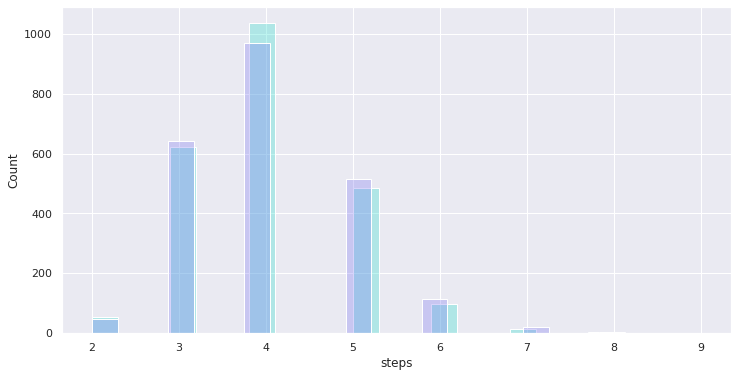

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.figure(figsize=(12,6))
sns.histplot(x='steps', data=df.loc[df.word.eq('tales')], alpha=0.3, color='#27ddcb')
sns.histplot(x='steps', data=df.loc[df.word.eq('pares')], alpha=0.3, color='#7b73f0')
plt.show()

(0.0, 7.0)

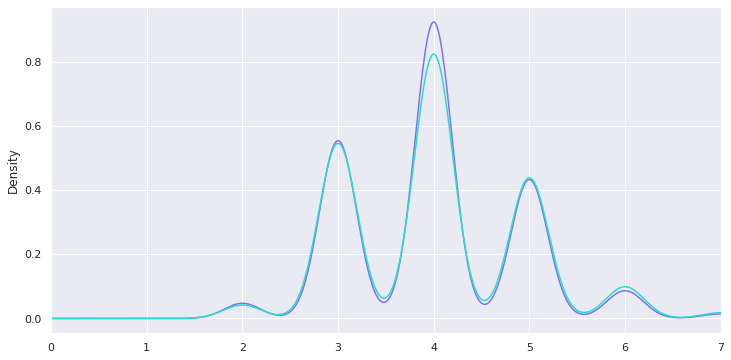

In [67]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
df.loc[df.word.eq('tales')].steps.plot.density(color='#7b73f0', ax=ax)
df.loc[df.word.eq('pares')].steps.plot.density(color='#27ddcb', ax=ax)
plt.xlim(0, 7)